In [1]:
cd ..

/home/x1112373/clinicalBERT/CS598-project


In [2]:
from modeling.modeling_utils import *

In [3]:
import os
ROOT_PATH = '/home/x1112373/clinicalBERT/CS598-project/discharge_seqcls_BATCH_SIZE_32_MAX_LEGNTH_128_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3'
dir_list = os.listdir(ROOT_PATH)

In [4]:
experiment_list = sorted(list(filter(lambda x: ('eval_results' in x), dir_list)))

In [5]:
experiment_list

['eval_results_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3.txt']

In [6]:
result_list = []
for experiment in experiment_list:
    f = open(ROOT_PATH + '/' + experiment, "r")
    get_result = f.readlines()
    result_dict = {}
    for res in get_result:    
        
        key = res.split('=')[0].strip()
        value = round(float(res.split('=')[1].split('\n')[0].strip()), 3)
        result_dict[key] = value
    learning_rate = experiment.split('_')[4]
    gradient_accumulate = experiment.split('_')[7]
    max_grad_norm = experiment.split('_')[-1].split('.')[0]
    result_dict['learning_rate'] = learning_rate
    result_dict['gradient_accumulate'] = gradient_accumulate
    result_dict['max_grad_norm'] = max_grad_norm
    result_dict['model_path'] = experiment
    result_list.append(result_dict)

In [7]:
pd.DataFrame(result_list).sort_values(by='AUROC')[::-1]

,AUPRC,AUROC,RP80,eval_accuracy,eval_loss,global_step,training loss,learning_rate,gradient_accumulate,max_grad_norm,model_path
0,0.624,0.672,0.017,0.577,1.152,0.0,0.256,2e-05,1,3,eval_results_LEARNING_RATE_2e-05_gradient_accu...


In [8]:
cd modeling/

/home/x1112373/clinicalBERT/CS598-project/modeling


In [9]:
from modeling.modeling_utils import *
processors = {
        "readmission": readmissionProcessor
    }
processor = processors['readmission']()
label_list = processor.get_labels()
dev_example = processor.get_dev_examples('/home/x1112373/clinicalBERT/data/discharge/')
test_example = processor.get_test_examples('/home/x1112373/clinicalBERT/data/discharge/')
test_2_example = processor.get_test_examples('/home/x1112373/clinicalBERT/data/discharge/')
labels = set(label_list)
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)
print(len(test_example))

{'0': 0, '1': 1}
3063


In [10]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer
BERT_MODEL = "pretraining"
proxies = {'http': 'http://10.40.84.229:10203', 'https': 'http://10.40.84.229:10203'}
#tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='/home/x1112373/clinicalBERT/BioClinicalBERT_Tokenizer')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', proxies=proxies) 
#model = AutoModel.from_pretrained(BERT_MODEL)

In [11]:
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32
EVAL_BATCH = 2
dev_features = convert_examples_to_features(
        dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_features(
        test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
test_2days_features = convert_examples_to_features(
        test_2_example, label_list, MAX_SEQ_LENGTH, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
04/17/2022 20:56:24 - INFO - modeling.modeling_utils -   *** Example ***
04/17/2022 20:56:24 - INFO - modeling.modeling_utils -   guid: val-0
04/17/2022 20:56:24 - INFO - modeling.modeling_utils -   tokens: [CLS] date of birth : sex : f service : medicine all ##er ##gies : pen ##ici ##llins / per ##co ##ce ##t attending : chief complaint : nausea , vomit ##ting , abdominal pain , h ##t ##n urge ##nc major surgical or invasive procedure : upper gi end ##os ##co ##py ex ##pl ##ora ##tory lap ##aro ##tom ##y tunnel ##ed hem ##od ##ial ##ysis cat ##het ##er in r fe ##moral vein hem ##od ##ial ##ysis history of present illness : ms . is a 24 y / o f with h / o es ##rd , h ##t ##n who started per ##ito ##nea ##l dial ##ysis during the week of and presented with a 1 day history of acute onset n / v , sharp abdomin

Max Sequence Length: 1319


04/17/2022 20:56:32 - INFO - modeling.modeling_utils -   *** Example ***
04/17/2022 20:56:32 - INFO - modeling.modeling_utils -   guid: test-0
04/17/2022 20:56:32 - INFO - modeling.modeling_utils -   tokens: [CLS] date of birth : sex : f service : medicine all ##er ##gies : hal ##do ##l attending : chief complaint : delta ms , let ##har ##gy , ? sep ##sis . major surgical or invasive procedure : none history of present illness : h ##x obtained per ed notes and sister . hp ##i : 35 ##f with disease who presented today from day ##care after her healthcare providers noted that she was let ##har ##gic . they were initially unable to obtain a blood pressure . the patient was noted to have a very rapid heart rate . vital ##s were finally obtained and were as follows : bp 70 / 50 ( baseline sb ##ps 80 - 90 ) , hr 113 , o ##2 sat 99 % on 3 ##l nc . . the patient was transferred to where she was noted to have a te ##mp of 4 , hr 200 and sb ##p 80s . ek ##g was noteworthy for a wide complex ta #

Max Sequence Length: 1346
Max Sequence Length: 1346


In [12]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
test_2days_dataloader = get_data_loader(test_2days_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)

 

In [13]:
dev_loader = get_data_loader(dev_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)

In [14]:
from bert_utils import BertForSequenceClassification
device = 'cuda:3'
model = BertForSequenceClassification.from_pretrained('/home/x1112373/clinicalBERT/CS598-project/pretraining', 1)

04/17/2022 20:56:36 - INFO - bert_utils -   loading archive file /home/x1112373/clinicalBERT/CS598-project/pretraining
04/17/2022 20:56:36 - INFO - bert_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



in the modeling class


In [15]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('/home/x1112373/clinicalBERT/CS598-project/pretraining', 1)
model.to(device)
m = nn.Sigmoid()

In [ ]:

model.eval()
correct = 0
eval_loss = 0
eval_accuracy = 0
nb_eval_steps = 0
nb_eval_examples = 0
pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
for step, batch in enumerate(tqdm(test_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
        logits = model(input_ids,segment_ids,input_mask) # we don't need twice

    logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
    label_ids = np.array(np.array(label_ids.to('cpu')))
    outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
    tmp_eval_accuracy=np.sum(outputs == label_ids)


    pred_labels += list(outputs)
    true_labels += list(label_ids)
    logits_history = logits_history + logits.flatten().tolist()
    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps 
eval_accuracy = eval_accuracy / nb_eval_examples
print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')

### Result with pretraining model for test Performance

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/discharge/test.csv')
df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
print('accuracy') 
print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])

In [ ]:
vote_pr_curve(df_test, logits_history, 'tmp')

In [ ]:
model_path_list = sorted(list(filter(lambda x: ('LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3' in x), dir_list)))
model_path_list

## check for best result 
- LEARNING_RATE : 2e-05
- GRADIENT_ACCUMULATE : X
- MAX_GRAD_NORM : 3

## check belows
- dev set
- 3days test set
- 2days test set

In [16]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [17]:
get_n_params(model)

109483009

Evaluation iteration: 100%|██████████| 1519/1519 [01:19<00:00, 19.18it/s]


Epoch: 002, Train loss: 0.6210, Test loss: 0.6595


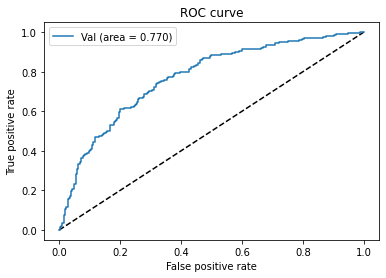

accuracy
0.6595324333223576
Recall at Precision of 80 is {} 0.43205574912891986


Evaluation iteration: 100%|██████████| 1519/1519 [01:19<00:00, 19.10it/s]


Epoch: 002, Train loss: 0.6160, Test loss: 0.6645


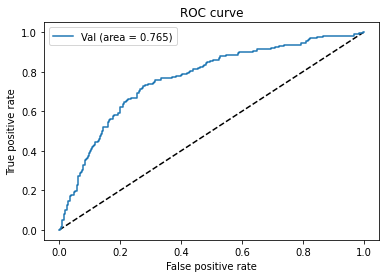

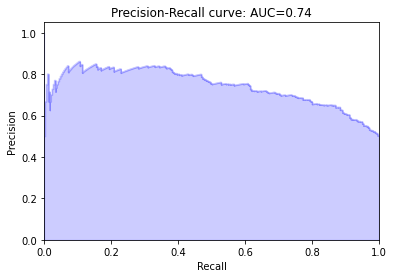

accuracy
0.6644715179453408
Recall at Precision of 80 is {} 0.3623693379790941


Evaluation iteration: 100%|██████████| 1519/1519 [01:19<00:00, 19.09it/s]


Epoch: 002, Train loss: 0.6762, Test loss: 0.6579


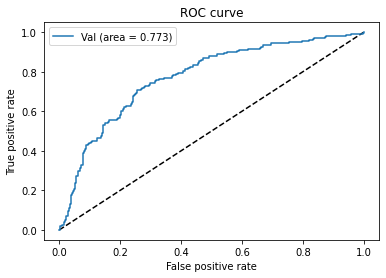

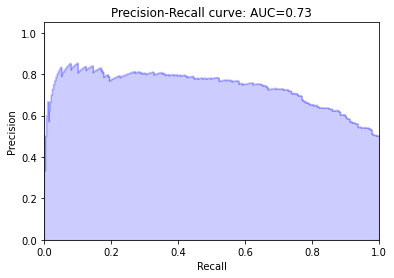

accuracy
0.6578860717813632
Recall at Precision of 80 is {} 0.44947735191637633


<Figure size 432x288 with 0 Axes>

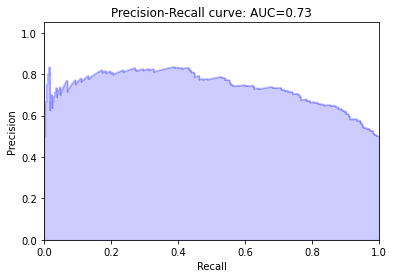

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3'
model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(dev_loader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/discharge/val.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')

Evaluation iteration: 100%|██████████| 1532/1532 [01:20<00:00, 19.09it/s]


Epoch: 002, Train loss: 0.6209, Test loss: 0.6663


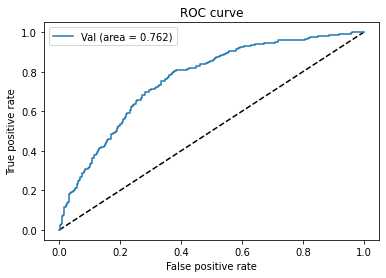

accuracy
0.6663401893568397
Recall at Precision of 80 is {} 0.2482758620689655
-------


Evaluation iteration: 100%|██████████| 1532/1532 [01:20<00:00, 19.09it/s]


Epoch: 002, Train loss: 0.6112, Test loss: 0.6644


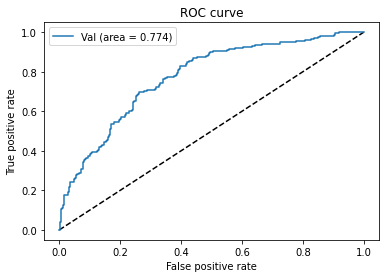

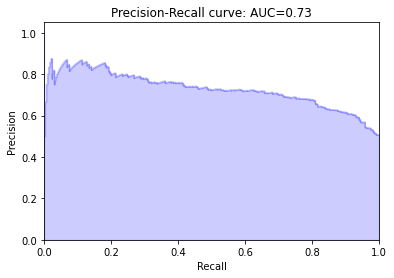

accuracy
0.6643813254978779
Recall at Precision of 80 is {} 0.3620689655172414
-------


Evaluation iteration: 100%|██████████| 1532/1532 [01:20<00:00, 19.09it/s]


Epoch: 002, Train loss: 0.6609, Test loss: 0.6706


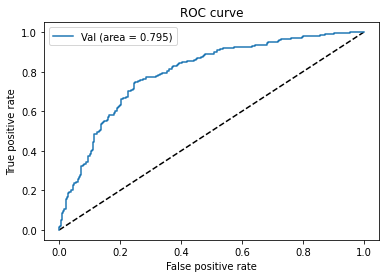

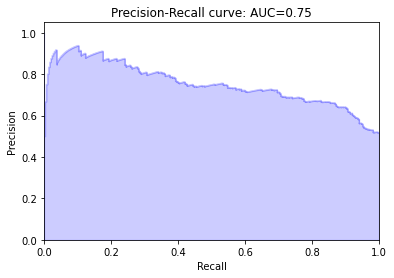

accuracy
0.6705843943845903
Recall at Precision of 80 is {} 0.4827586206896552
-------


<Figure size 432x288 with 0 Axes>

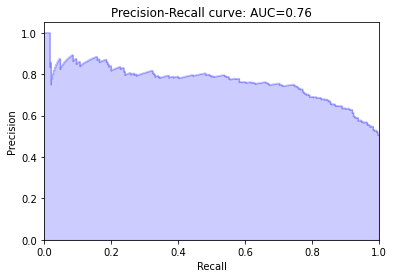

In [21]:
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3'

model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(test_dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/discharge/test.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')
    print('-------')